In [3]:
from util import *
import json
import os
with open('./hidden_unit_activity/prompt_bank.json', 'r') as file:
    prompt_bank = json.load(file)
from huggingface_hub import login
login(token="YOURTOKENHERE")
import transformers
import torch
import numpy as np
import re
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import MambaConfig, MambaForCausalLM, AutoTokenizer

# Define the device
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

def load_llama3(model_id="meta-llama/Meta-Llama-3-8B", device=device): # 33 layers, 4096 embedding dimension
    # Load the model and tokenizer
    model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    return model, tokenizer


def load_T5(model_id="t5-small", device=device): # 7 encoder layer, 512 embedding dimension 
    # Load the model and tokenizer
    tokenizer = T5Tokenizer.from_pretrained("t5-small")
    model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)
    return model, tokenizer


def load_mamba(model_id="state-spaces/mamba-130m-hf", device=device): # mamba has 25 layers and  768 embedding dimension
    # Load the model and tokenizer 
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = MambaForCausalLM.from_pretrained(model_id).to(device)
    return model, tokenizer

def load_RWKV(model_id= "RWKV/rwkv-4-169m-pile", device = device): # RWKV has 13 layers
    tokenizer = AutoTokenizer.from_pretrained(model_id)    
    model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
    return model, tokenizer 

/mnt/data3/swu/miniforge3/envs/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def decode_chunks_all_models(word, trainkey, testkey, prompt_bank,device, tokenizer, model_name='T5', step = 0, n_training = 5, partword = False):     
    experiment_data = [] # record experiment data 
    
    ######### decode chunks in other models  ############
    input_text = prompt_bank[trainkey]
    if trainkey == 'austen-emma.txt':tokens = get_token_austin(tokenizer, input_text,device)
    else:tokens = obtain_sentence_wise_token(tokenizer, input_text,device)
    if model_name == 'T5': tokens = [token.replace('▁', ' ') for token in tokens]
    indices = get_word_indices_in_sequence(tokens, word, step = step) # n step predictive of the upcoming sequence
    if partword: indices = get_word_indices_in_sequence_partword(tokens, word, step = step) # n step predictive of the upcoming sequence

    if model_name == 'llama3': nlayer = 33
    elif model_name == 'T5': nlayer = 7
    elif model_name == 'mamba': nlayer = 25
    elif model_name == 'rwkv': nlayer = 13

    print('length of indices = ', len(indices))
    if len(indices)>=10: # word becomes eligible for population averaging when the nunber of occurrance exceed 10 in the training data
        plot = False
        neural_chunk_dictionary = {}
        try:
            with open(f"./neural_chunk_dictionary/neural_chunk_dictionary_model={model_name}.pkl", "rb") as file:
                neural_chunk_dictionary = pickle.load(file)
        except FileNotFoundError:
            print("Dictionary file not found. Starting with an empty dictionary.")
        
        # Manually ensure intermediate levels exist
        if word not in neural_chunk_dictionary:neural_chunk_dictionary[word] = {}
        if step not in neural_chunk_dictionary[word]: neural_chunk_dictionary[word][step] = {}
        if 'layer' not in neural_chunk_dictionary[word][step]:neural_chunk_dictionary[word][step]['layer'] = {}
        print('finished loading files ')

        for l in range(0, nlayer): neural_chunk_dictionary[word][step]['layer'][l] = {}
        
        max_accs, max_tps, layers, optimal_threshold, deviation_threshold, n_relevant_neurons, minmax_FP, aucs = [],[],[],[],[],[],[],[]
        
        for l in range(0,nlayer)[:]: # 
            layer = l
            # print('layer = ', layer)
            hidden_state = np.load(f'./hidden_unit_activity/{trainkey}_concatenated_hidden_state_layer_{layer}_model={model_name}.npy')
            exp_growth_list = [100, 30, 20, 10, 3] + [1 * 0.8**i for i in range(35)]# Create a list with exponential growth
        
            tps, fps, accs, n_neurons = [], [], [], []
            max_acc, max_tp, best_tol, best_threshold = (0,) * 4
        
            for tol in exp_growth_list:
                constant_positions,constant_values, TP_rate, FP_rate, accuracy,dev_threshold = get_TP_FP(hidden_state, indices, tokens, tolerance = tol,n_training = n_training)
                tps.append(TP_rate)
                fps.append(FP_rate)
                accs.append(accuracy)
                n_neurons.append(len(constant_positions))
        
                if accuracy>max_acc:
                    max_acc = accuracy
                    best_tol = tol
                    best_threshold = dev_threshold 
                    neural_chunk_dictionary[word][step]['layer'][l]['constant_values'] = constant_values
                    neural_chunk_dictionary[word][step]['layer'][l]['constant_positions'] = constant_positions
                    neural_chunk_dictionary[word][step]['layer'][l]['tolerance'] = dev_threshold
                if TP_rate > max_tp:max_tp = TP_rate
        
            
            temp = []
            for i in range(0, len(tps)):
                if tps[i]>=max_tp:temp.append(fps[i])
            
            fps_sorted, tps_sorted = zip(*sorted(zip(fps, tps)))
            fps_sorted = fps_sorted + (1,)
            tps_sorted = tps_sorted + (1,)
            auc = np.trapezoid(tps_sorted, fps_sorted)
        
            minmax_FP.append(min(temp))
            layers.append(layer)
            max_accs.append(max_acc)
            max_tps.append(max_tp)
            optimal_threshold.append(best_tol)
            n_relevant_neurons.append(n_neurons[np.argmax(accs)])
            deviation_threshold.append(best_threshold)
            experiment_data.append({'Model': model_name, 'Word': word ,'step': step, 'TP': TP_rate, 'FP': FP_rate,'n_training': n_training, 'Layer': layer, 'Training': True, 'Test': False})

            aucs.append(auc)
            minmax_FP.append(min(temp))
            layers.append(layer)
            max_accs.append(max_acc)
            max_tps.append(max_tp)
            optimal_threshold.append(best_tol)
            n_relevant_neurons.append(n_neurons[np.argmax(accs)])
            deviation_threshold.append(best_threshold)
            
            if plot: make_figure(fps_sorted, tps_sorted, exp_growth_list, tps, fps, n_neurons, accs,model_name = model_name)
        
        
        with open(f"./neural_chunk_dictionary/neural_chunk_dictionary_model={model_name}.pkl", "wb") as file:
            pickle.dump(neural_chunk_dictionary, file)
    
        plot_decoding_performance(layers, max_tps, minmax_FP, step = step, word = word, testdata = False,model_name = model_name)
        plot_layer_statistics(layers, optimal_threshold,n_relevant_neurons,deviation_threshold,word,step,model_name = model_name)

        print('======================================== evaluate on test data ==============================================')

        if testkey == 'austen-persuasion.txt':tokens = get_token_austin(tokenizer, input_text,device)
        else:tokens = obtain_sentence_wise_token(tokenizer, input_text,device)

        input_text = prompt_bank[testkey]
        tokens = obtain_sentence_wise_token(tokenizer, input_text,device)

        if model_name == 'T5': tokens = [token.replace('▁', ' ') for token in tokens]

        indices = get_word_indices_in_sequence(tokens, word, step = step)
        if partword: indices = get_word_indices_in_sequence_partword(tokens, word, step = step) # n step predictive of the upcoming sequence

        if word in neural_chunk_dictionary:
            layers, accs, tps, fps = [], [], [], []
            for layer in range(0,nlayer): # 
                # Load the hidden state from the saved file
                hidden_state = np.load(f'./hidden_unit_activity/{testkey}_concatenated_hidden_state_layer_{layer}_model={model_name}.npy')  # Shape: (batch_size, sequence_length, hidden_size)    
                TP_rate, FP_rate, accuracy = eval_TP_FP(indices, hidden_state, neural_chunk_dictionary[word][step], layer)
                print(TP_rate, FP_rate, accuracy)
                experiment_data.append({'Model': model_name, 'Word': word ,'step': step, 'TP': TP_rate, 'FP': FP_rate,'n_training': n_training, 'Layer': layer, 'Training': False, 'Test': True})
                for lst, value in zip([accs, tps, fps, layers], [accuracy, TP_rate, FP_rate, layer]):
                    lst.append(value)
        
        plot_decoding_performance(layers, tps, fps, word = word, step = step, testdata = True, model_name = model_name)

        
        return experiment_data # returns a list of dictionary 

In [3]:
def get_word_indices_in_sequence(tokens, word, step = 0):
    '''step:  the number of previous step (used to find components responsible for predicting an upcoming token)'''
    ######### find token occurrance ############
    variants = [word[0].lower(), word[0].upper(), word.upper(), word.lower()]
    spaces = ['',' ']
    combinations = [f"{space_before}{first_letter}{word[1:]}{space_after}" for first_letter, (space_before, space_after) in itertools.product(variants, itertools.product(spaces, repeat=2))]
    indices = [] # indices of identified token 
    for i in range(0, len(tokens)):
        # first letter lower, first letter upper, space in 
        if tokens[i] in combinations: 
            indices.append(i-step)
    # for i in indices:print('------'+tokens[i] + '--------')
    return indices 

def get_word_indices_in_sequence_partword(tokens, word, step = 0):
    # step: int               step backward, population responsible for predicting the next token
    
    ######### find token occurrance ############
    limit = 5
    variants = [word[0].lower(), word[0].upper()]
    spaces = ['',' ']
    combinations = [f"{space_before}{first_letter}{word[1:]}{space_after}" for first_letter, (space_before, space_after) in itertools.product(variants, itertools.product(spaces, repeat=2))]
    indices = [] # indices of identified token 
    for i in range(0, len(tokens)):
        # first letter lower, first letter upper, space in 
        if any(comb in tokens[i] for comb in combinations):  # Substring matching
            indices.append(i-step)
        else: # if the word is broken into parts, obtain the index of the token that marks the end of the word 
            check = False 
            if tokens[i] in word or tokens[i][1:] in word:
                k = 1
                tokenword = tokens[i]
                check = True 
            while check: 
                if tokenword.startswith('_'):
                    tokenword = tokens[i - k] + tokenword[1:] # check if tokenword belongs to any of the word variants 
                else:
                    tokenword = tokens[i - k] + tokenword # check if tokenword belongs to any of the word variants 
                if tokenword in combinations or tokenword[1:] in combinations: 
                    indices.append(i-step)# append the last index (the token finishing point) to the indice checker 
                k = k + 1
                if k>=limit:break
    return indices 

Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.25it/s]


length of indices =  24
finished loading files 


/shared-network/swu/code/util.py:147: RuntimeWarning: invalid value encountered in scalar divide
  dev = np.sum((template_hidden_state - constant_values)**2)/template_hidden_state.size
/shared-network/swu/code/util.py:165: RuntimeWarning: invalid value encountered in scalar divide
  dev = np.sum((template_hidden_state - constant_values)**2)/template_hidden_state.size


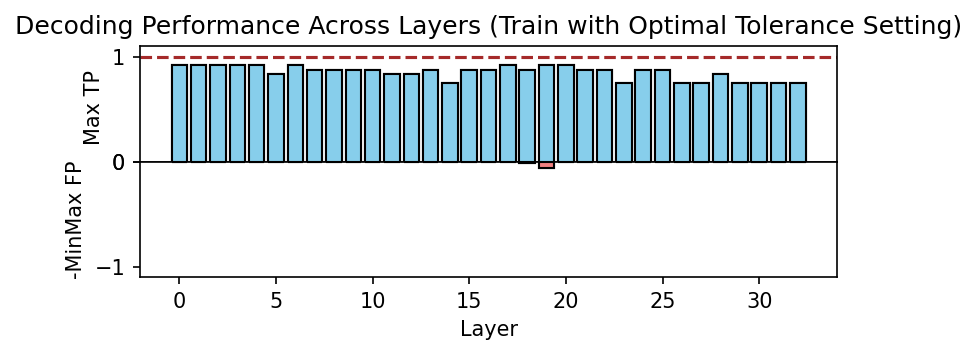

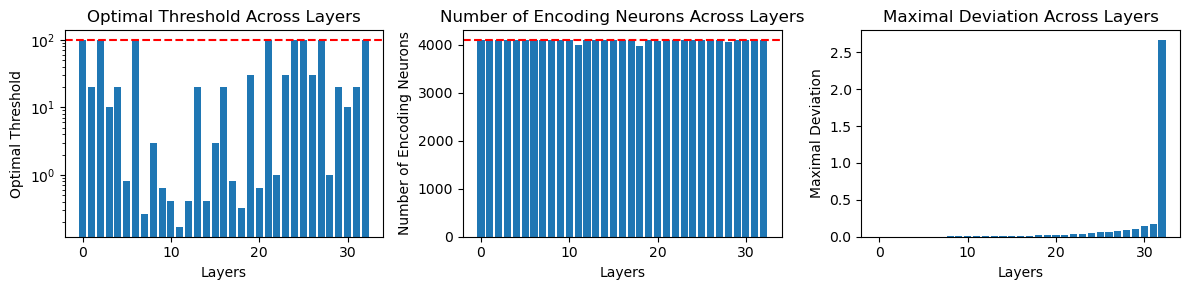

======================================== evaluate on test data ==============================================
0.875 0.0 1.0
0.8333333333333334 0.0 0.9977011494252873
0.7083333333333334 0.0 0.9908045977011494
0.7916666666666666 0.0 0.9954022988505747
0.7916666666666666 0.0 0.9954022988505747
0.6666666666666666 0.0 0.9885057471264368
0.8333333333333334 0.0 0.9977011494252873
0.7083333333333334 0.0 0.9908045977011494
0.7083333333333334 0.0 0.9908045977011494
0.7083333333333334 0.0 0.9908045977011494
0.75 0.0 0.993103448275862
0.7083333333333334 0.0 0.9908045977011494
0.6666666666666666 0.0 0.9885057471264368
0.7083333333333334 0.0 0.9908045977011494
0.6666666666666666 0.0 0.9885057471264368
0.7916666666666666 0.0 0.9954022988505747
0.8333333333333334 0.0 0.9977011494252873
0.7916666666666666 0.0 0.9954022988505747
0.7083333333333334 0.0072992700729927005 0.9839080459770115
0.7916666666666666 0.0 0.9954022988505747
0.7916666666666666 0.0024330900243309003 0.993103448275862
0.79166666666666

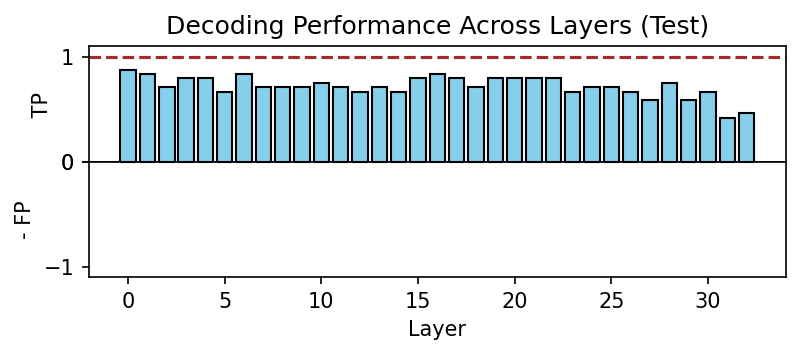

length of indices =  14
finished loading files 


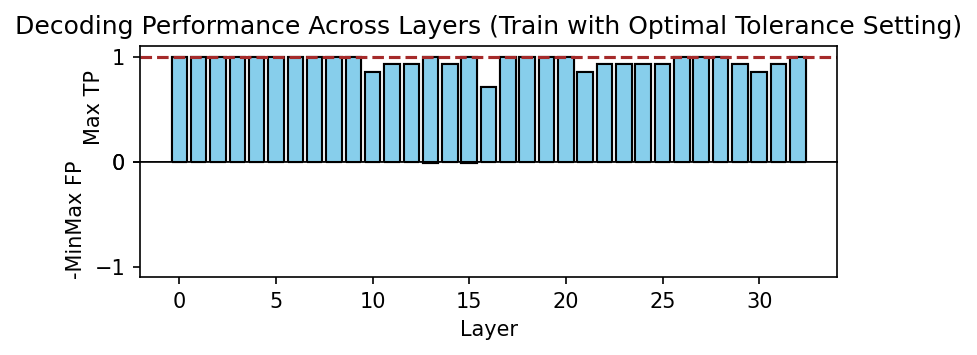

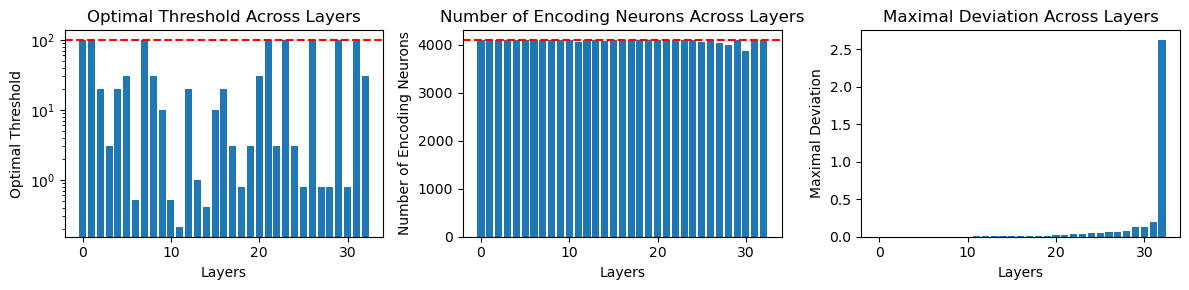

======================================== evaluate on test data ==============================================
1.0 0.0 1.0
1.0 0.0 1.0
1.0 0.0 1.0
0.9166666666666666 0.0 0.9977011494252873
1.0 0.0 1.0
0.9166666666666666 0.0 0.9977011494252873
0.9166666666666666 0.0 0.9977011494252873
0.75 0.0 0.993103448275862
0.75 0.0 0.993103448275862
0.75 0.0 0.993103448275862
0.5 0.0 0.9862068965517241
0.5 0.0 0.9862068965517241
0.3333333333333333 0.0 0.9816091954022989
0.8333333333333334 0.004728132387706856 0.9908045977011494
0.75 0.0 0.993103448275862
0.75 0.0 0.993103448275862
0.6666666666666666 0.0 0.9908045977011494
0.6666666666666666 0.0 0.9908045977011494
0.75 0.004728132387706856 0.9885057471264368
0.5 0.0 0.9862068965517241
0.75 0.0 0.993103448275862
0.4166666666666667 0.0 0.9839080459770115
0.9166666666666666 0.0 0.9977011494252873
0.5833333333333334 0.0 0.9885057471264368
0.8333333333333334 0.0 0.9954022988505747
0.75 0.0 0.993103448275862
0.8333333333333334 0.0 0.9954022988505747
0.75 0

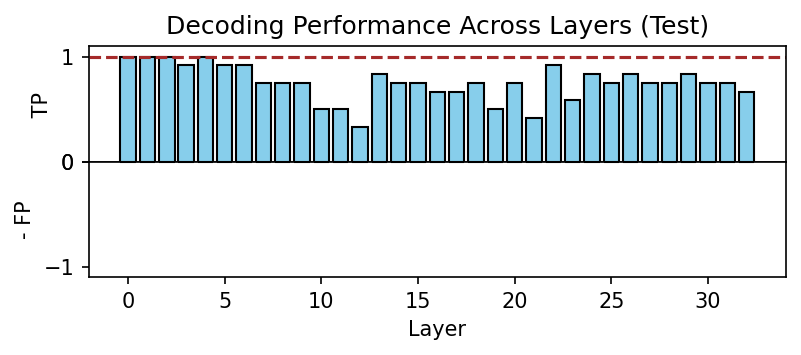

length of indices =  37
finished loading files 


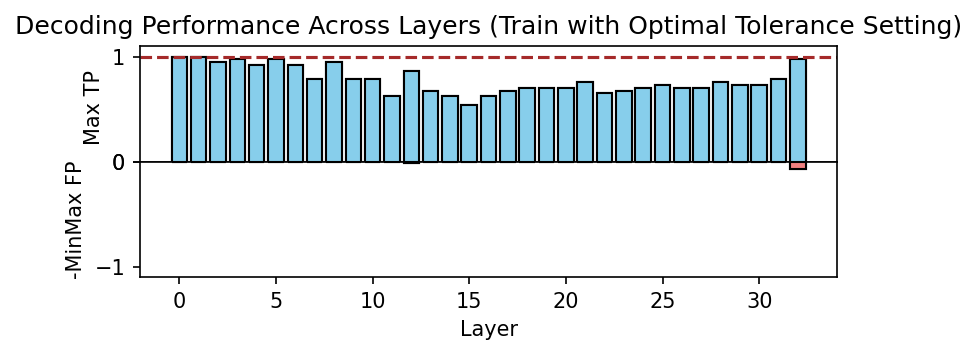

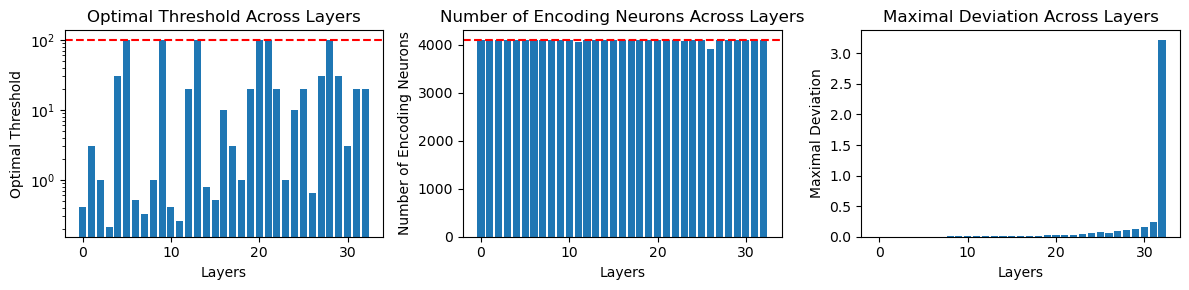

======================================== evaluate on test data ==============================================
1.0 0.0 1.0
1.0 0.0 1.0
0.9428571428571428 0.0 0.9954022988505747
1.0 0.0 1.0
0.8571428571428571 0.0 0.9885057471264368
0.9428571428571428 0.0 0.9954022988505747
0.8857142857142857 0.0 0.9908045977011494
0.7428571428571429 0.0 0.9793103448275862
0.9428571428571428 0.005 0.9908045977011494
0.7428571428571429 0.0 0.9793103448275862
0.7714285714285715 0.0 0.9816091954022989
0.6285714285714286 0.0 0.9701149425287356
0.8571428571428571 0.015 0.9747126436781609
0.5714285714285714 0.0 0.9655172413793104
0.6285714285714286 0.0 0.9701149425287356
0.5142857142857142 0.0 0.960919540229885
0.5428571428571428 0.0 0.9632183908045977
0.6 0.0025 0.9655172413793104
0.6285714285714286 0.0025 0.967816091954023
0.5428571428571428 0.0 0.9632183908045977
0.7142857142857143 0.0 0.9770114942528736
0.7714285714285715 0.0 0.9816091954022989
0.5142857142857142 0.0 0.960919540229885
0.6 0.0 0.967816091954

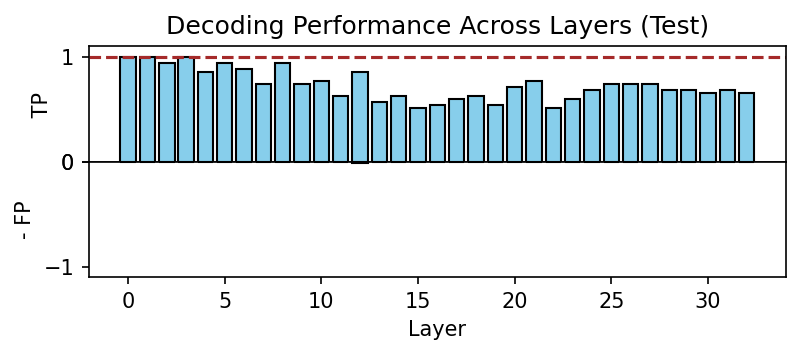

In [4]:
# first test on step = 0
model_names = ['llama3'] # 'T5'#,'mamba','rwkv',
words = ['cheesecake', 'cheese','cake']
steps = [0]

trainkey = 'prompt_with_cheesecake_train'
testkey = 'prompt_with_cheesecake_test'
experiment_data = [] # record experiment data 

for model_name in model_names:
    if model_name == 'llama3':
        model, tokenizer = load_llama3(model_id="meta-llama/Meta-Llama-3-8B", device=device)
    if model_name == 'T5':
        model, tokenizer = load_T5(model_id="t5-small", device=device)
    if model_name == 'mamba':
        model, tokenizer = load_mamba(model_id="state-spaces/mamba-130m-hf", device=device)
    if model_name == 'rwkv':
        model, tokenizer = load_RWKV(model_id= "RWKV/rwkv-4-169m-pile", device = device)
        
    for word in words:
        for step in steps: 
            exp_data = decode_chunks_all_models(word, trainkey, testkey, prompt_bank, device, tokenizer, model_name=model_name, step = step, n_training = 5, partword = True)     
            if exp_data!=None:
                experiment_data = experiment_data + exp_data
                df = pd.DataFrame(experiment_data)
                df.to_csv('./cheesecake_llama_population_averaging_eval.csv', index=False)

            # input_text = prompt_bank[trainkey]
            # tokens = obtain_sentence_wise_token(tokenizer, input_text, device)